In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from tabulate import tabulate

from const import MIN_TIMESTEP

In [ ]:
DATE_FORMAT = '%Y-%m-%dT%H:%H%M%z'  # ISO 8601 datetime format

Define a functions to load and plot the capacity factor data.

In [13]:
def load_cf_data(tech: str) -> pd.DataFrame:
    """Load cf data from intermediate files"""
    df = (pd.read_csv(f'../data/intermediate/CF {tech}.csv',
                        index_col=0, parse_dates=True)
              .dropna(axis=1, how='all'))
    df.index.name = 'Datetime'
    df.columns.name = 'Country code'
    return df


def plot_cf_statistics(cf: pd.DataFrame):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    cf.plot.box(title='Capacity factor', ax=ax1)
    cf.interpolate('time').diff(1).plot.box(title=f'{MIN_TIMESTEP} changes in CF', ax=ax2)
    return ax1, ax2

## Results for onshore wind power

Let’s plot some statistics about the CF time series and the change time series. Note that also for countries with only hourly data, changes are calculated from interpolated 15-minute time series to make them comparable.

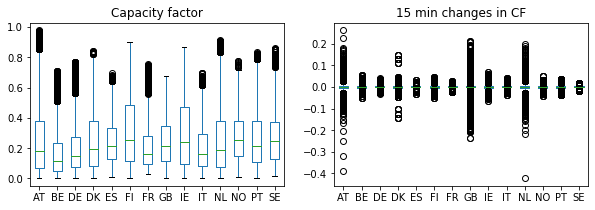

In [14]:
cf_wind_onshore = load_cf_data('Wind Onshore')
plot_cf_statistics(cf_wind_onshore);

Some very high values for Austria (AT). Let’s plot the time series.

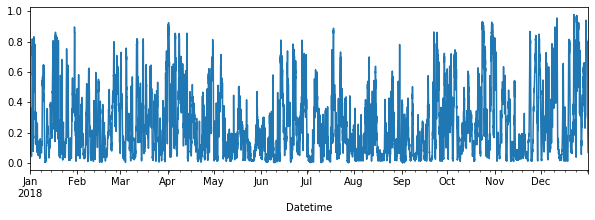

In [20]:
cf_wind_onshore['AT'].plot(figsize=(10, 3));

Let’s look at the installed capacities. We used numbers from WindEurope in the cap. factors calculations. ENTSO-E also has that data.

In [21]:
installed_cap_windeurope = pd.read_csv('../data/intermediate/WindEurope_installed_cap.csv', 
                                       index_col=0, header=[0,1])
installed_cap_entsoe = pd.read_csv("../data/raw/ENTSO-E_TP_installed_cap.csv", 
                                   index_col=[0, 1], header=0)
wind_cap_onshore_at = pd.DataFrame({'windeurope': installed_cap_windeurope.loc['Austria', 
                                                                               'Cumulative onshore capacity'],
                                    'entso-e': installed_cap_entsoe.loc['Wind Onshore', 'AT']})
wind_cap_onshore_at

,windeurope,entso-e
Year,,
2017,2844.0,2696.0
2018,3045.0,2887.0


Let’s calculate means too.

In [22]:
wind_cap_onshore_at.mean()

windeurope    2944.5
entso-e       2791.5
dtype: float64

It seems that ENTSO-E has on average lower installed capacity which then should not lead to too *high* capacity factors.

Write final files, including data for Austria.

In [23]:
cf_wind_onshore.to_csv('../data/processed/CF Wind Onshore.csv', header=True)

## Results for offshore wind power

Let’s plot the same statistics for offshore wind.

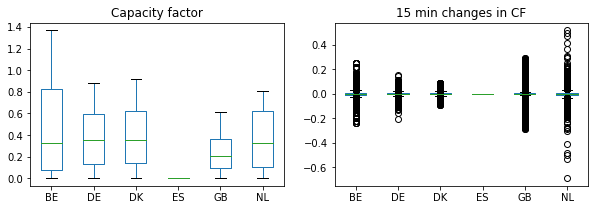

In [25]:
tech = 'Wind Offshore'
cf_wind_offshore = load_cf_data(tech)
plot_cf_statistics(cf_wind_offshore);

Clearly something wrong with Belgium and Spain. Let’s plot the time series.

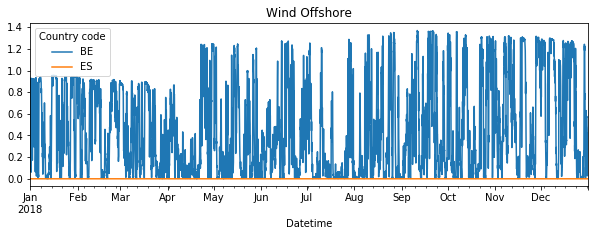

In [28]:
cf_wind_offshore[['BE', 'ES']].dropna().plot(figsize=(10, 3), title=tech);

Clearly, Spain acctually has no data. There is a big jump in the CF values in Belgium in April/May, after which values are above 1. 

Let’s also plot the generation data for Belgium.

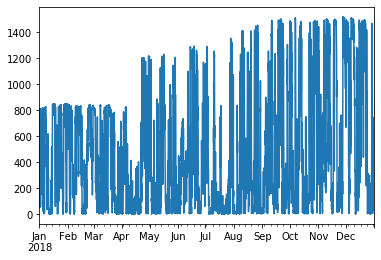

In [29]:
gen = pd.read_csv('../data/intermediate/Generation Wind Offshore.csv', index_col=0, parse_dates=True)
gen['BE'].dropna().plot();

The jump in generation is visible here too in April/May. 

Let’s compare the installed capacity between WindEurope and ENTSO-E TP.

In [30]:
wind_cap_onshore_be = pd.DataFrame({'windeurope': installed_cap_windeurope.loc['Belgium', 
                                                                               'Cumulative offshore capacity'],
                                    'entso-e': installed_cap_entsoe.loc['Wind Offshore', 'BE']})
wind_cap_onshore_be

,windeurope,entso-e
Year,,
2017,876.0,877.0
2018,1186.0,1178.0


In [31]:
wind_cap_onshore_be.mean()

windeurope    1031.0
entso-e       1027.5
dtype: float64

Not much difference here, but the values are way too low for the actual generation after the April/May jump. Something is wrong.

Write final files, excluding data for Belgium and Spain.

In [32]:
cf_wind_offshore.drop(['BE', 'ES'], axis=1).to_csv('../data/processed/CF Wind Offshore.csv', header=True)

## Solar power

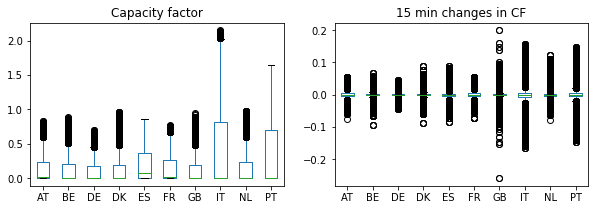

In [34]:
cf_solar = load_cf_data('Solar')
plot_cf_statistics(cf_solar);

Data for Italy and Portugal is errorneous. Let’s drop these.

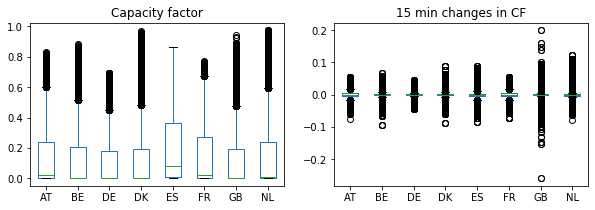

In [36]:
plot_cf_statistics(cf_solar.drop(['IT', 'PT'], axis=1));

Let’s check the maximum values still.

In [37]:
cf_solar.drop(['IT', 'PT'], axis=1).max()

Country code
AT    0.834773
BE    0.887233
DE    0.694729
DK    0.969398
ES    0.861849
FR    0.769545
GB    0.946543
NL    0.975872
dtype: float64

None above one at least. Let’s write final files.

In [45]:
cf_solar.drop(['IT', 'PT'], axis=1).to_csv('../data/processed/CF Solar.csv', header=True)